In [ ]:
# First, try reinstalling
# !pip uninstall normalizer -y
!pip install normalizer

# Or try a different version
# !pip install normalizer

!pip install git+https://github.com/csebuetnlp/normalizer
!pip install --upgrade transformers
!pip install torch transformers datasets pandas scikit-learn

# Normal Working Implementation 

Using: cuda
Data: (6000, 4), Labels: {1: 3000, 0: 3000}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Training XLM-R...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.546700,0.620778,0.716667,0.711002,0.735098,0.716667
1000,0.399800,0.549368,0.765000,0.764103,0.769093,0.765000
1500,0.288700,0.587792,0.764167,0.763338,0.767918,0.764167
2000,0.176100,0.764848,0.780833,0.780148,0.784379,0.780833
2500,0.142800,0.842089,0.771667,0.771644,0.771775,0.771667
3000,0.120600,0.853341,0.774167,0.774052,0.774723,0.774167


Free disk space: 4.96 GB
Free disk space: 1.85 GB
Free disk space: 1.85 GB
Free disk space: 1.85 GB
Free disk space: 1.85 GB
Free disk space: 1.85 GB
Training complete!



Results: Acc=0.717, F1=0.711, AUC=0.794


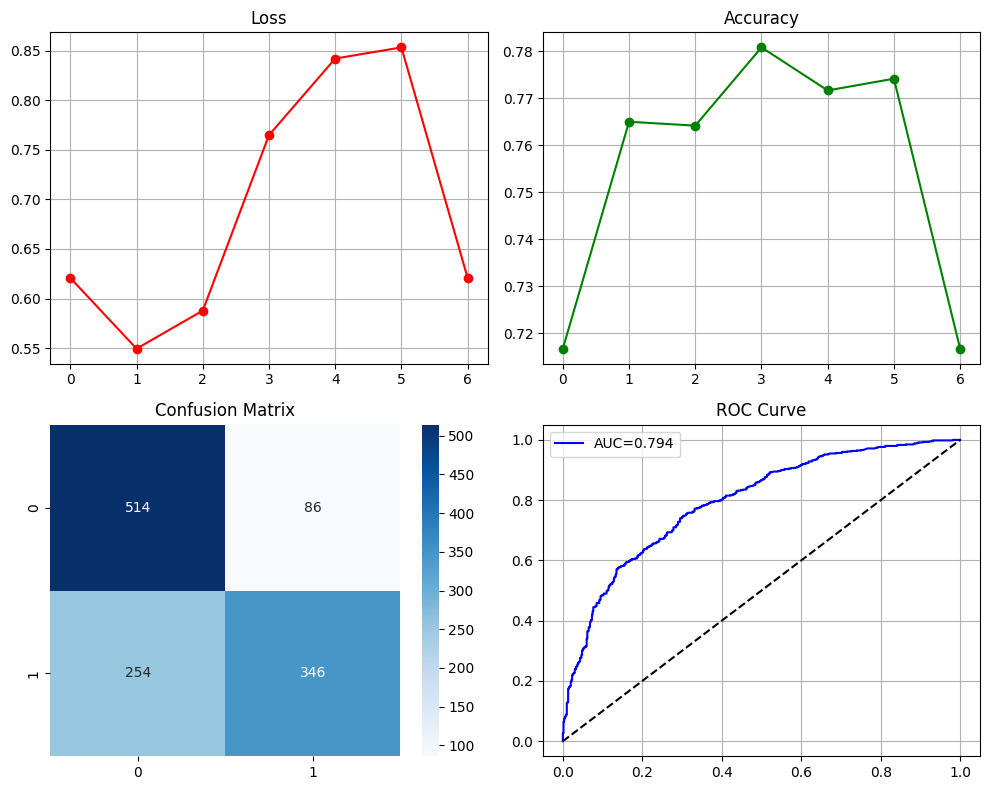

XLM-R model saved!
'আমি তোমাকে ভালোবাসি।' -> Non-Hate (0.935)
'You are terrible!' -> Non-Hate (0.860)
'Je te déteste!' -> Non-Hate (0.904)
'Ich liebe dich' -> Non-Hate (0.921)

🎉 Done! Use predict('text') for multilingual inference


In [18]:
# XLM-R Hate Speech Detection - Ultra Compact (FIXED)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from datasets import Dataset
import torch
from collections import defaultdict
import warnings; warnings.filterwarnings('ignore')
import gc
import os

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Load data
def load_data():
    for path in ['/kaggle/input/final-hate-speech/combined_final_hate_speech.csv', './combined_final_hate_speech.csv', 'combined_final_hate_speech.csv']:
        try: return pd.read_csv(path)
        except: continue
    raise FileNotFoundError("Dataset not found")

# Text normalizer (simple for XLM-R)
def normalize_text(text):
    return str(text).strip().replace('\n', ' ').replace('\r', ' ')

# Process data
df = load_data().dropna(subset=['Comment', 'Hate'])
df['text'] = df['Comment'].apply(normalize_text)
df['label'] = df['Hate'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
df = df.dropna(subset=['label']).astype({'label': int})
print(f"Data: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")

# Split & tokenize
train_df, eval_df = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42, stratify=df['label'])
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2).to(device)

def tokenize(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
eval_dataset = Dataset.from_pandas(eval_df).map(tokenize, batched=True)
for ds in [train_dataset, eval_dataset]:
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Enhanced Trainer with memory management
class QuickTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
    
    def log(self, logs, start_time=None):
        super().log(logs)
        for k, v in logs.items(): 
            self.history[k].append(v)
    
    def _save_checkpoint(self, model, trial):
        # Clean up before saving
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        # Check disk space before saving
        output_dir = self.args.output_dir
        if os.path.exists(output_dir):
            statvfs = os.statvfs(output_dir)
            free_space_gb = (statvfs.f_frsize * statvfs.f_bavail) / (1024**3)
            print(f"Free disk space: {free_space_gb:.2f} GB")
            
            if free_space_gb < 2:  # Less than 2GB free
                print("Warning: Low disk space! Skipping checkpoint save.")
                return
        
        try:
            super()._save_checkpoint(model, trial)
        except Exception as e:
            print(f"Checkpoint save failed: {e}")
            # Continue training without saving
            pass

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': accuracy_score(labels, preds), 'f1': f1, 'precision': p, 'recall': r}

# Create output directory with better path
output_dir = './xlmr_results'
os.makedirs(output_dir, exist_ok=True)

# Train - FIXED Configuration
trainer = QuickTrainer(
    model=model,
    args=TrainingArguments(
        output_dir=output_dir,
        eval_strategy="steps", 
        save_strategy="steps",
        learning_rate=1e-5, 
        per_device_train_batch_size=16, 
        per_device_eval_batch_size=32,
        num_train_epochs=10, 
        weight_decay=0.1, 
        logging_steps=50, 
        report_to="none",
        load_best_model_at_end=True, 
        metric_for_best_model="eval_f1", 
        greater_is_better=True,
        fp16=torch.cuda.is_available(), 
        dataloader_num_workers=0, 
        warmup_steps=300,
        # FIXED: Less frequent saves and limited checkpoints
        eval_steps=500,  # Increased from 200
        save_steps=500,  # Increased from 200
        save_total_limit=2,  # Only keep 2 checkpoints
        gradient_accumulation_steps=2, 
        max_grad_norm=1.0,
        # Additional memory optimizations
        remove_unused_columns=True,
        prediction_loss_only=False,
        save_safetensors=True,  # More efficient saving format
    ),
    train_dataset=train_dataset, 
    eval_dataset=eval_dataset, 
    compute_metrics=compute_metrics,
)

print("Training XLM-R...")
try:
    trainer.train()
    print("Training complete!")
except Exception as e:
    print(f"Training failed: {e}")
    # Try to save what we have
    try:
        model.save_pretrained('./xlmr_model_partial')
        tokenizer.save_pretrained('./xlmr_model_partial')
        print("Partial model saved!")
    except:
        print("Could not save partial model")

# Clean up before evaluation
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Evaluate
try:
    preds = trainer.predict(eval_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)
    y_true = preds.label_ids
    y_prob = torch.softmax(torch.tensor(preds.predictions), dim=1)[:, 1].numpy()

    results = trainer.evaluate()
    auc = roc_auc_score(y_true, y_prob)
    print(f"\nResults: Acc={results['eval_accuracy']:.3f}, F1={results['eval_f1']:.3f}, AUC={auc:.3f}")

    # Plots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    if 'eval_loss' in trainer.history:
        axes[0,0].plot(trainer.history['eval_loss'], 'r-o'); axes[0,0].set_title('Loss'); axes[0,0].grid()
    if 'eval_accuracy' in trainer.history:
        axes[0,1].plot(trainer.history['eval_accuracy'], 'g-o'); axes[0,1].set_title('Accuracy'); axes[0,1].grid()
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues'); axes[1,0].set_title('Confusion Matrix')
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[1,1].plot(fpr, tpr, 'b-', label=f'AUC={auc:.3f}')
    axes[1,1].plot([0,1], [0,1], 'k--'); axes[1,1].set_title('ROC Curve'); axes[1,1].legend(); axes[1,1].grid()
    plt.tight_layout(); plt.savefig('xlmr_results.png', dpi=300, bbox_inches='tight'); plt.show()

except Exception as e:
    print(f"Evaluation failed: {e}")

# Save final model
try:
    model.save_pretrained('./xlmr_model')
    tokenizer.save_pretrained('./xlmr_model')
    print("XLM-R model saved!")
except Exception as e:
    print(f"Model save failed: {e}")

# Hugging Face deploy
def deploy_to_hf(username, model_name="xlmr-hate-speech"):
    try:
        from huggingface_hub import login, HfApi
        login()  # Enter your HF token
        repo_id = f"{username}/{model_name}"
        model.push_to_hub(repo_id)
        tokenizer.push_to_hub(repo_id)
        print(f"✅ Model deployed: https://huggingface.co/{repo_id}")
        return repo_id
    except Exception as e:
        print(f"❌ Deploy failed: {e}")
        return None

# Uncomment to deploy: deploy_to_hf("your_username")

def predict(text):
    inputs = tokenizer(normalize_text(text), return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    pred = torch.argmax(probs).item()
    return {'text': text, 'prediction': 'Hate' if pred == 1 else 'Non-Hate', 'confidence': probs.max().item()}

# Test multilingual
for text in ["আমি তোমাকে ভালোবাসি।", "You are terrible!", "Je te déteste!", "Ich liebe dich"]:
    try:
        result = predict(text)
        print(f"'{text}' -> {result['prediction']} ({result['confidence']:.3f})")
    except Exception as e:
        print(f"Prediction failed for '{text}': {e}")

print("\n🎉 Done! Use predict('text') for multilingual inference")

In [ ]:
deploy_to_hf("tajuarAkash")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

# Quick inference function

In [ ]:
def predict(text):
    inputs = tokenizer(normalize_text(text), return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    
    pred = torch.argmax(probs).item()
    
    return {
        'text': text,
        'prediction': 'Hate' if pred == 1 else 'Non-Hate',
        'confidence': probs.max().item(),
        'hate_prob': probs[1].item()
    }

# Test
name_input = input("Enter text: ")
result = predict(name_input)
print(f"\n'{result['text']}' -> {result['prediction']} (Confidence: {result['confidence']:.3f})")


# Improved Implementation 

In [ ]:
# Enhanced XLM-R Hate Speech Detection - Ultra Compact with Advanced Techniques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from datasets import Dataset
import torch
import torch.nn as nn
from collections import defaultdict
import warnings; warnings.filterwarnings('ignore')
import gc
import os
import re
import random

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Load data
def load_data():
    for path in ['/kaggle/input/final-hate-speech/combined_final_hate_speech.csv', './combined_final_hate_speech.csv', 'combined_final_hate_speech.csv']:
        try: return pd.read_csv(path)
        except: continue
    raise FileNotFoundError("Dataset not found")

# Enhanced text preprocessing
def enhanced_preprocess(text):
    """Enhanced preprocessing with multilingual support"""
    text = str(text).strip()
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single
    text = text.replace('\n', ' ').replace('\r', ' ')
    return text.strip()

# Data Augmentation Functions
def synonym_replace(text, n=2):
    """Multilingual synonym replacement"""
    # Extended for multiple languages
    synonyms = {
        'bad': ['terrible', 'awful', 'horrible'], 'good': ['great', 'excellent', 'amazing'],
        'খারাপ': ['বাজে', 'নিকৃষ্ট', 'অসৎ'], 'ভালো': ['উত্তম', 'চমৎকার', 'সুন্দর'],
        'mauvais': ['terrible', 'horrible'], 'bon': ['excellent', 'formidable']
    }
    
    words = text.split()
    new_words = words.copy()
    for i, word in enumerate(words):
        if word in synonyms and random.random() < 0.3:
            new_words[i] = random.choice(synonyms[word])
    return ' '.join(new_words)

def random_insertion(text, n=1):
    """Insert random words from the text itself"""
    words = text.split()
    if len(words) < 2: return text
    for _ in range(n):
        if random.random() < 0.1:
            random_word = random.choice(words)
            random_idx = random.randint(0, len(words))
            words.insert(random_idx, random_word)
    return ' '.join(words)

def random_deletion(text, p=0.05):
    """Randomly delete words"""
    words = text.split()
    if len(words) == 1: return text
    new_words = [word for word in words if random.random() > p]
    return ' '.join(new_words) if new_words else text

def augment_text(text, label):
    """Apply augmentation techniques"""
    if random.random() < 0.3:  # 30% chance to augment
        augmented = text
        if random.random() < 0.4: augmented = synonym_replace(augmented)
        if random.random() < 0.3: augmented = random_insertion(augmented)
        if random.random() < 0.2: augmented = random_deletion(augmented)
        return augmented
    return text

# Enhanced Model with Dropout
class EnhancedXLMRModel(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.3):
        super().__init__()
        self.xlmr = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.xlmr(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        if labels is not None:
            return outputs
        # Apply additional dropout during inference
        logits = self.dropout(outputs.logits)
        return type(outputs)(logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

# Process data with enhanced preprocessing
df = load_data().dropna(subset=['Comment', 'Hate'])
df['text'] = df['Comment'].apply(enhanced_preprocess)
df['label'] = df['Hate'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
df = df.dropna(subset=['label']).astype({'label': int})

# Remove duplicates and filter short texts
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
df = df[df['text'].str.len() > 3]  # Remove very short texts

print(f"Data: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")

# Data Augmentation for minority class balancing
def balance_with_augmentation(df, target_ratio=0.6):
    """Balance dataset using augmentation"""
    hate_df = df[df['label'] == 1]
    non_hate_df = df[df['label'] == 0]
    
    # Augment hate speech samples if minority
    if len(hate_df) < len(non_hate_df):
        needed = int(len(non_hate_df) * target_ratio) - len(hate_df)
        augmented_samples = []
        
        for _ in range(needed):
            sample = hate_df.sample(1).iloc[0]
            augmented_text = augment_text(sample['text'], sample['label'])
            augmented_samples.append({'text': augmented_text, 'label': sample['label']})
        
        aug_df = pd.DataFrame(augmented_samples)
        df = pd.concat([df, aug_df], ignore_index=True)
    
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

df = balance_with_augmentation(df)
print(f"After augmentation: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")

# Split & tokenize
train_df, eval_df = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42, stratify=df['label'])
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = EnhancedXLMRModel("xlm-roberta-base").to(device)

def tokenize(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
eval_dataset = Dataset.from_pandas(eval_df).map(tokenize, batched=True)
for ds in [train_dataset, eval_dataset]:
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Enhanced Trainer with Memory Management & Custom Optimizer
class EnhancedTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
    
    def create_optimizer(self):
        """Custom optimizer with different learning rates for different layers"""
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.args.weight_decay,
                "lr": self.args.learning_rate
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": self.args.learning_rate
            }
        ]
        self.optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=1e-8)
        return self.optimizer
    
    def create_scheduler(self, num_training_steps: int, optimizer=None):
        """Custom scheduler with warmup"""
        if optimizer is None:
            optimizer = self.optimizer
        self.lr_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
            num_training_steps=num_training_steps
        )
        return self.lr_scheduler
    
    def log(self, logs, start_time=None):
        super().log(logs)
        for k, v in logs.items(): 
            self.history[k].append(v)
    
    def _save_checkpoint(self, model, trial):
        # Clean up before saving
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        # Check disk space before saving
        output_dir = self.args.output_dir
        if os.path.exists(output_dir):
            statvfs = os.statvfs(output_dir)
            free_space_gb = (statvfs.f_frsize * statvfs.f_bavail) / (1024**3)
            print(f"Free disk space: {free_space_gb:.2f} GB")
            
            if free_space_gb < 2:  # Less than 2GB free
                print("Warning: Low disk space! Skipping checkpoint save.")
                return
        
        try:
            super()._save_checkpoint(model, trial)
        except Exception as e:
            print(f"Checkpoint save failed: {e}")
            pass

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': accuracy_score(labels, preds), 'f1': f1, 'precision': p, 'recall': r}

# Create output directory
output_dir = './enhanced_xlmr_results'
os.makedirs(output_dir, exist_ok=True)

# Enhanced Training Arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="steps", 
    save_strategy="steps",
    learning_rate=2e-5,  # Optimized learning rate
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=32,
    num_train_epochs=10,  # Increased epochs
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=50, 
    report_to="none",
    load_best_model_at_end=True, 
    metric_for_best_model="eval_f1", 
    greater_is_better=True,
    fp16=torch.cuda.is_available(), 
    dataloader_num_workers=0,
    eval_steps=300,  # More frequent evaluation
    save_steps=300,
    save_total_limit=3,  # Keep more checkpoints
    gradient_accumulation_steps=2, 
    max_grad_norm=1.0,
    adam_epsilon=1e-8,
    lr_scheduler_type="linear",
    remove_unused_columns=True,
    prediction_loss_only=False,
    save_safetensors=True,
)

# Train with Enhanced Trainer
trainer = EnhancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, 
    eval_dataset=eval_dataset, 
    compute_metrics=compute_metrics,
)

print("Training Enhanced XLM-R...")
try:
    trainer.train()
    print("Training complete!")
except Exception as e:
    print(f"Training failed: {e}")
    # Try to save what we have
    try:
        model.xlmr.save_pretrained('./enhanced_xlmr_partial')
        tokenizer.save_pretrained('./enhanced_xlmr_partial')
        print("Partial model saved!")
    except:
        print("Could not save partial model")

# Clean up before evaluation
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Evaluate
try:
    preds = trainer.predict(eval_dataset)
    y_pred = np.argmax(preds.predictions, axis=1)
    y_true = preds.label_ids
    y_prob = torch.softmax(torch.tensor(preds.predictions), dim=1)[:, 1].numpy()

    results = trainer.evaluate()
    auc = roc_auc_score(y_true, y_prob)
    print(f"\nEnhanced Results: Acc={results['eval_accuracy']:.3f}, F1={results['eval_f1']:.3f}, AUC={auc:.3f}")

    # Enhanced Plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    if 'eval_loss' in trainer.history:
        axes[0,0].plot(trainer.history['eval_loss'], 'r-o', linewidth=2); axes[0,0].set_title('Validation Loss'); axes[0,0].grid()
    if 'eval_accuracy' in trainer.history:
        axes[0,1].plot(trainer.history['eval_accuracy'], 'g-o', linewidth=2); axes[0,1].set_title('Validation Accuracy'); axes[0,1].grid()
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues', cbar_kws={'label': 'Count'}); axes[1,0].set_title('Confusion Matrix')
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[1,1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC={auc:.3f}')
    axes[1,1].plot([0,1], [0,1], 'k--', alpha=0.6); axes[1,1].set_title('ROC Curve'); axes[1,1].legend(); axes[1,1].grid()
    plt.tight_layout(); plt.savefig('enhanced_xlmr_results.png', dpi=300, bbox_inches='tight'); plt.show()

    # Training history summary
    print(f"\nTraining Summary:")
    print(f"Best Accuracy: {max(trainer.history['eval_accuracy']):.3f}")
    print(f"Best F1: {max(trainer.history['eval_f1']):.3f}")
    print(f"Final Loss: {trainer.history['eval_loss'][-1]:.3f}")

except Exception as e:
    print(f"Evaluation failed: {e}")

# Save final model
try:
    model.xlmr.save_pretrained('./enhanced_xlmr_model')
    tokenizer.save_pretrained('./enhanced_xlmr_model')
    print("Enhanced XLM-R model saved!")
except Exception as e:
    print(f"Model save failed: {e}")

# Enhanced prediction function with confidence threshold
def predict(text, confidence_threshold=0.7):
    """Enhanced prediction with preprocessing and confidence threshold"""
    processed_text = enhanced_preprocess(text)
    inputs = tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.xlmr(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    
    pred = torch.argmax(probs).item()
    confidence = probs.max().item()
    
    # Apply confidence threshold
    if confidence < confidence_threshold:
        prediction = "Uncertain"
    else:
        prediction = 'Hate' if pred == 1 else 'Non-Hate'
    
    return {
        'text': text,
        'processed_text': processed_text,
        'prediction': prediction,
        'confidence': confidence,
        'probabilities': {'Non-Hate': probs[0].item(), 'Hate': probs[1].item()}
    }

# Hugging Face deploy
def deploy_to_hf(username, model_name="enhanced-xlmr-hate-speech"):
    try:
        from huggingface_hub import login, HfApi
        login()  # Enter your HF token
        repo_id = f"{username}/{model_name}"
        model.xlmr.push_to_hub(repo_id)
        tokenizer.push_to_hub(repo_id)
        print(f"✅ Enhanced model deployed: https://huggingface.co/{repo_id}")
        return repo_id
    except Exception as e:
        print(f"❌ Deploy failed: {e}")
        return None

# Enhanced multilingual test
test_samples = [
    "আমি তোমাকে ভালোবাসি।",  # Bengali: I love you
    "You are terrible!",        # English: Negative
    "Je te déteste!",           # French: I hate you
    "Ich liebe dich",           # German: I love you
    "তুমি একজন খারাপ মানুষ।",    # Bengali: You are a bad person
    "This is amazing work!",     # English: Positive
]

print("\nEnhanced Multilingual Predictions:")
for text in test_samples:
    try:
        result = predict(text)
        print(f"'{text}' -> {result['prediction']} (Confidence: {result['confidence']:.3f})")
        print(f"  Probabilities: Non-Hate={result['probabilities']['Non-Hate']:.3f}, Hate={result['probabilities']['Hate']:.3f}")
    except Exception as e:
        print(f"Prediction failed for '{text}': {e}")

# Uncomment to deploy: deploy_to_hf("your_username")

print("\n🎉 Enhanced XLM-R training complete! Use predict('text') for improved multilingual inference")

# Improvised version (final one)

In [ ]:
# Enhanced XLM-R Hate Speech Detection - Optimized & Complete

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, EarlyStoppingCallback
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import warnings; warnings.filterwarnings('ignore')
import gc, os, re, random, json
from typing import Dict, List, Tuple

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Utility functions
def load_data():
    """Load dataset from multiple possible paths"""
    paths = ['/kaggle/input/final-hate-speech/combined_final_hate_speech.csv', 
             './combined_final_hate_speech.csv', 'combined_final_hate_speech.csv']
    for path in paths:
        try: return pd.read_csv(path)
        except: continue
    raise FileNotFoundError("Dataset not found")

def enhanced_preprocess(text):
    """Enhanced multilingual text preprocessing"""
    if pd.isna(text): return ""
    text = str(text).strip()
    text = re.sub(r'\s+', ' ', text).replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)
    text = re.sub(r'[^\w\s\!\?\.\,\;\:\-\'\"\(\)\[\]।]', '', text)
    return text.strip()

# Advanced Data Augmentation
class AdvancedAugmentation:
    def __init__(self):
        self.synonyms = {
            # English
            'bad': ['terrible', 'awful', 'horrible', 'nasty', 'disgusting'],
            'good': ['great', 'excellent', 'amazing', 'wonderful', 'fantastic'],
            'hate': ['despise', 'loathe', 'detest', 'abhor'],
            'love': ['adore', 'cherish', 'appreciate', 'like'],
            'stupid': ['dumb', 'foolish', 'idiotic', 'moronic'],
            'smart': ['intelligent', 'clever', 'brilliant', 'wise'],
            # Bengali
            'খারাপ': ['বাজে', 'নিকৃষ্ট', 'অসৎ', 'ভয়ানক'],
            'ভালো': ['উত্তম', 'চমৎকার', 'সুন্দর', 'দারুণ'],
            'ঘৃণা': ['অপছন্দ', 'বিদ্বেষ', 'শত্রুতা'],
            'ভালোবাসা': ['প্রেম', 'স্নেহ', 'ভালোবাসি'],
           
        }
        
        self.context_words = {
            'en': ['really', 'very', 'quite', 'extremely', 'totally'],
            'bn': ['খুবই', 'অত্যন্ত', 'বেশ', 'সত্যিই'],
            
        }
    
    def detect_language(self, text):
        """Simple language detection"""
        if any(char in text for char in 'আইউএওকখগঘচছজঝটঠডঢণতথদধনপফবভমযরলশষসহ'):
            return 'bn'
        elif any(word in text.lower() for word in ['je', 'tu', 'il', 'le', 'la', 'de', 'et']):
            return 'fr'
        elif any(word in text.lower() for word in ['ich', 'du', 'er', 'sie', 'das', 'der', 'die', 'und']):
            return 'de'
        return 'en'
    
    def synonym_replace(self, text, n=2):
        """Replace words with synonyms"""
        words = text.split()
        new_words = words.copy()
        for i, word in enumerate(words):
            if word.lower() in self.synonyms and random.random() < 0.3:
                new_words[i] = random.choice(self.synonyms[word.lower()])
        return ' '.join(new_words)
    
    def random_insertion(self, text, n=1):
        """Insert context words based on language"""
        words = text.split()
        if len(words) < 2: return text
        
        lang = self.detect_language(text)
        new_words = words.copy()
        
        for _ in range(n):
            if random.random() < 0.15:
                context_word = random.choice(self.context_words.get(lang, self.context_words['en']))
                random_idx = random.randint(0, len(new_words))
                new_words.insert(random_idx, context_word)
        
        return ' '.join(new_words)
    
    def random_deletion(self, text, p=0.1):
        """Conservative deletion preserving important words"""
        words = text.split()
        if len(words) <= 2: return text
        
        important_words = ['not', 'no', 'never', 'nothing', 'না', 'নেই', 'কখনো']
        
        new_words = [word for word in words 
                    if word.lower() in important_words or random.random() > p]
        
        return ' '.join(new_words) if new_words else text
    
    def back_translation_simulation(self, text):
        """Simulate back translation word order changes"""
        words = text.split()
        if len(words) > 3 and random.random() < 0.2:
            idx = random.randint(0, len(words) - 2)
            words[idx], words[idx + 1] = words[idx + 1], words[idx]
        return ' '.join(words)
    
    def augment_text(self, text, label, strength=0.3):
        """Apply multiple augmentation techniques"""
        if random.random() > strength: return text
        
        augmented = text
        if random.random() < 0.4: augmented = self.synonym_replace(augmented)
        if random.random() < 0.3: augmented = self.random_insertion(augmented)
        if random.random() < 0.2: augmented = self.random_deletion(augmented)
        if random.random() < 0.1: augmented = self.back_translation_simulation(augmented)
        
        return augmented

# Enhanced data processing
def process_data_enhanced(df):
    """Enhanced data processing with quality control"""
    # Initial cleaning
    df = df.dropna(subset=['Comment', 'Hate'])
    df['text'] = df['Comment'].apply(enhanced_preprocess)
    df['label'] = df['Hate'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
    df = df.dropna(subset=['label']).astype({'label': int})
    
    # Remove duplicates and filter
    df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
    df = df[(df['text'].str.len() > 5) & (df['text'].str.len() < 500)]
    
    # Remove near-duplicates for larger datasets
    if len(df) > 1000:
        try:
            vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
            tfidf_matrix = vectorizer.fit_transform(df['text'])
            similarity_matrix = cosine_similarity(tfidf_matrix)
            
            to_remove = set()
            for i in range(len(similarity_matrix)):
                for j in range(i + 1, len(similarity_matrix)):
                    if similarity_matrix[i][j] > 0.9:
                        to_remove.add(j)
            
            df = df.drop(df.index[list(to_remove)]).reset_index(drop=True)
            print(f"Removed {len(to_remove)} near-duplicate samples")
        except:
            print("Near-duplicate removal failed, continuing...")
    
    return df

def balance_with_advanced_augmentation(df, target_ratio=0.55):
    """Balance dataset with quality augmentation"""
    augmenter = AdvancedAugmentation()
    
    hate_df = df[df['label'] == 1]
    non_hate_df = df[df['label'] == 0]
    
    print(f"Original distribution - Hate: {len(hate_df)}, Non-Hate: {len(non_hate_df)}")
    
    # Determine augmentation needs
    if len(hate_df) < len(non_hate_df):
        minority_class, minority_label = hate_df, 1
        needed = min(int(len(non_hate_df) * target_ratio), len(non_hate_df)) - len(hate_df)
    else:
        minority_class, minority_label = non_hate_df, 0
        needed = min(int(len(hate_df) * target_ratio), len(hate_df)) - len(non_hate_df)
    
    if needed > 0:
        print(f"Augmenting {needed} samples for class {minority_label}")
        augmented_samples = []
        samples_per_original = max(1, needed // len(minority_class))
        
        for idx, row in minority_class.iterrows():
            for _ in range(min(samples_per_original, 3)):
                augmented_text = augmenter.augment_text(row['text'], row['label'])
                
                if (augmented_text != row['text'] and 
                    len(augmented_text.split()) >= 2 and 
                    len(augmented_text) > 5):
                    augmented_samples.append({
                        'text': augmented_text,
                        'label': minority_label
                    })
                    
                    if len(augmented_samples) >= needed:
                        break
            
            if len(augmented_samples) >= needed:
                break
        
        if augmented_samples:
            aug_df = pd.DataFrame(augmented_samples)
            df = pd.concat([df, aug_df], ignore_index=True)
            print(f"Added {len(augmented_samples)} augmented samples")
    
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

# Enhanced Trainer
class EnhancedTrainerV2(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
        self.class_weights = class_weights
        self.best_metrics = {'eval_f1': 0, 'eval_accuracy': 0}
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Enhanced loss with class weights and focal loss"""
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Apply class weights
        if self.class_weights is not None:
            weight = torch.tensor(self.class_weights, device=logits.device, dtype=logits.dtype)
            loss_fct = nn.CrossEntropyLoss(weight=weight)
        else:
            loss_fct = nn.CrossEntropyLoss()
        
        # Calculate losses
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        # Add focal loss component
        pt = torch.exp(-loss)
        focal_loss = (1 - pt) ** 2 * loss
        total_loss = 0.7 * loss + 0.3 * focal_loss
        
        return (total_loss, outputs) if return_outputs else total_loss
    
    def create_optimizer(self):
        """Layer-wise learning rate decay"""
        no_decay = ["bias", "LayerNorm.weight"]
        
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() 
                          if not any(nd in n for nd in no_decay) and "roberta.embeddings" in n],
                "weight_decay": self.args.weight_decay,
                "lr": self.args.learning_rate * 0.1
            },
            {
                "params": [p for n, p in self.model.named_parameters() 
                          if not any(nd in n for nd in no_decay) and "roberta.encoder" in n],
                "weight_decay": self.args.weight_decay,
                "lr": self.args.learning_rate * 0.5
            },
            {
                "params": [p for n, p in self.model.named_parameters() 
                          if not any(nd in n for nd in no_decay) and "classifier" in n],
                "weight_decay": self.args.weight_decay,
                "lr": self.args.learning_rate
            },
            {
                "params": [p for n, p in self.model.named_parameters() 
                          if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": self.args.learning_rate
            }
        ]
        
        self.optimizer = AdamW(optimizer_grouped_parameters, 
                              lr=self.args.learning_rate, 
                              eps=1e-8, betas=(0.9, 0.999))
        return self.optimizer
    
    def create_scheduler(self, num_training_steps: int, optimizer=None):
        """Enhanced scheduler with warmup"""
        if optimizer is None:
            optimizer = self.optimizer
        
        warmup_steps = int(0.1 * num_training_steps)
        self.lr_scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps
        )
        return self.lr_scheduler
    
    def log(self, logs, start_time=None):
        super().log(logs)
        for k, v in logs.items():
            self.history[k].append(v)
        
        # Track best metrics
        if 'eval_f1' in logs and logs['eval_f1'] > self.best_metrics['eval_f1']:
            self.best_metrics['eval_f1'] = logs['eval_f1']
        if 'eval_accuracy' in logs and logs['eval_accuracy'] > self.best_metrics['eval_accuracy']:
            self.best_metrics['eval_accuracy'] = logs['eval_accuracy']

def compute_enhanced_metrics(eval_pred):
    """Comprehensive metrics computation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    # Per-class metrics
    precision_per_class = precision_score(labels, predictions, average=None)
    recall_per_class = recall_score(labels, predictions, average=None)
    f1_per_class = f1_score(labels, predictions, average=None)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hate_precision': precision_per_class[1] if len(precision_per_class) > 1 else 0,
        'hate_recall': recall_per_class[1] if len(recall_per_class) > 1 else 0,
        'hate_f1': f1_per_class[1] if len(f1_per_class) > 1 else 0,
        'non_hate_precision': precision_per_class[0],
        'non_hate_recall': recall_per_class[0],
        'non_hate_f1': f1_per_class[0]
    }

def create_visualizations(trainer, y_true, y_pred, y_prob):
    """Create comprehensive visualizations"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Training history plots
    if 'eval_loss' in trainer.history:
        axes[0,0].plot(trainer.history['eval_loss'], 'r-o', linewidth=2, markersize=4)
        axes[0,0].set_title('Validation Loss', fontsize=14)
        axes[0,0].set_xlabel('Steps')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].grid(True, alpha=0.3)
    
    if 'eval_accuracy' in trainer.history:
        axes[0,1].plot(trainer.history['eval_accuracy'], 'g-o', linewidth=2, markersize=4)
        axes[0,1].set_title('Validation Accuracy', fontsize=14)
        axes[0,1].set_xlabel('Steps')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].grid(True, alpha=0.3)
    
    if 'eval_f1' in trainer.history:
        axes[0,2].plot(trainer.history['eval_f1'], 'b-o', linewidth=2, markersize=4)
        axes[0,2].set_title('Validation F1 Score', fontsize=14)
        axes[0,2].set_xlabel('Steps')
        axes[0,2].set_ylabel('F1 Score')
        axes[0,2].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues', 
                cbar_kws={'label': 'Count'}, 
                xticklabels=['Non-Hate', 'Hate'], 
                yticklabels=['Non-Hate', 'Hate'])
    axes[1,0].set_title('Confusion Matrix', fontsize=14)
    axes[1,0].set_xlabel('Predicted')
    axes[1,0].set_ylabel('Actual')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    axes[1,1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_score:.3f}')
    axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random')
    axes[1,1].set_xlabel('False Positive Rate')
    axes[1,1].set_ylabel('True Positive Rate')
    axes[1,1].set_title('ROC Curve', fontsize=14)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
    axes[1,2].plot(recall_curve, precision_curve, 'g-', linewidth=2)
    axes[1,2].set_xlabel('Recall')
    axes[1,2].set_ylabel('Precision')
    axes[1,2].set_title('Precision-Recall Curve', fontsize=14)
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('enhanced_xlmr_v2_results.png', dpi=300, bbox_inches='tight')
    plt.show()



# Main execution
def main():
    # Process data
    df = load_data()
    df = process_data_enhanced(df)
    df = balance_with_advanced_augmentation(df)
    
    print(f"Final data: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")
    
    # Train/test split
    X, y = df['text'], df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    # Create datasets
    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    val_df = pd.DataFrame({'text': X_val, 'label': y_val})
    test_df = pd.DataFrame({'text': X_test, 'label': y_test})
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    print(f"Class weights: {class_weights}")
    
    # Initialize model
    model_name = "xlm-roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    
    # Tokenization
    def tokenize_enhanced(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, 
                        max_length=256, return_attention_mask=True, add_special_tokens=True)
    
    # Create and format datasets
    train_dataset = Dataset.from_pandas(train_df).map(tokenize_enhanced, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(tokenize_enhanced, batched=True)
    test_dataset = Dataset.from_pandas(test_df).map(tokenize_enhanced, batched=True)
    
    for dataset in [train_dataset, val_dataset, test_dataset]:
        dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    # Training arguments
    output_dir = './enhanced_xlmr_v2_results'
    os.makedirs(output_dir, exist_ok=True)
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="steps",
        save_strategy="steps",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.01,
        warmup_steps=300,
        logging_steps=100,
        eval_steps=200,
        save_steps=400,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=2,
        gradient_accumulation_steps=2,
        max_grad_norm=1.0,
        adam_epsilon=1e-8,
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        remove_unused_columns=True,
        report_to="none",
        seed=42,
        data_seed=42,
        prediction_loss_only=False,
        dataloader_pin_memory=True,
    )
    
    # Initialize trainer
    trainer = EnhancedTrainerV2(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_enhanced_metrics,
        class_weights=class_weights,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    # Train
    print("Training Enhanced XLM-R v2...")
    try:
        trainer.train()
        print("Training completed successfully!")
        
        # Save model
        trainer.save_model('./enhanced_xlmr_v2_best')
        tokenizer.save_pretrained('./enhanced_xlmr_v2_best')
        
        print(f"Best metrics achieved:")
        print(f"- Best F1: {trainer.best_metrics['eval_f1']:.4f}")
        print(f"- Best Accuracy: {trainer.best_metrics['eval_accuracy']:.4f}")
        
    except Exception as e:
        print(f"Training failed: {e}")
        import traceback
        traceback.print_exc()
        return
    
    # Memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    # Evaluation
    print("\nEvaluating on test set...")
    try:
        eval_trainer = EnhancedTrainerV2(
            model=model,
            args=training_args,
            compute_metrics=compute_enhanced_metrics,
        )
        
        # Test evaluation
        test_results = eval_trainer.evaluate(test_dataset)
        predictions = eval_trainer.predict(test_dataset)
        
        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids
        y_prob = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
        
        # Calculate AUC
        auc_score = roc_auc_score(y_true, y_prob)
        
        # Print results
        print(f"\nFinal Test Results:")
        print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
        print(f"F1 Score: {test_results['eval_f1']:.4f}")
        print(f"Precision: {test_results['eval_precision']:.4f}")
        print(f"Recall: {test_results['eval_recall']:.4f}")
        print(f"AUC: {auc_score:.4f}")
        
        print(f"\nPer-class metrics:")
        print(f"Hate Speech - Precision: {test_results['eval_hate_precision']:.4f}, "
              f"Recall: {test_results['eval_hate_recall']:.4f}, "
              f"F1: {test_results['eval_hate_f1']:.4f}")
        print(f"Non-Hate - Precision: {test_results['eval_non_hate_precision']:.4f}, "
              f"Recall: {test_results['eval_non_hate_recall']:.4f}, "
              f"F1: {test_results['eval_non_hate_f1']:.4f}")
        
        # Create visualizations
        create_visualizations(trainer, y_true, y_pred, y_prob)
        
        # Save results
        results_summary = {
            'test_accuracy': test_results['eval_accuracy'],
            'test_f1': test_results['eval_f1'],
            'test_precision': test_results['eval_precision'],
            'test_recall': test_results['eval_recall'],
            'test_auc': auc_score,
            'hate_precision': test_results['eval_hate_precision'],
            'hate_recall': test_results['eval_hate_recall'],
            'hate_f1': test_results['eval_hate_f1'],
            'non_hate_precision': test_results['eval_non_hate_precision'],
            'non_hate_recall': test_results['eval_non_hate_recall'],
            'non_hate_f1': test_results['eval_non_hate_f1'],
            'training_history': dict(trainer.history)
        }
        
        with open('enhanced_xlmr_v2_results.json', 'w') as f:
            json.dump(results_summary, f, indent=2)
        
        print("\nResults saved to enhanced_xlmr_v2_results.json")
        print("Visualizations saved to enhanced_xlmr_v2_results.png")
        
    except Exception as e:
        print(f"Evaluation failed: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [ ]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, torch, torch.nn as nn, gc, re, random, json, warnings
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, get_linear_schedule_with_warmup, EarlyStoppingCallback
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset
from collections import defaultdict
from typing import Dict, List, Tuple

os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_data():
    for path in ['/kaggle/input/final-hate-speech/combined_final_hate_speech.csv', './combined_final_hate_speech.csv', 'combined_final_hate_speech.csv']:
        try: return pd.read_csv(path)
        except: continue
    raise FileNotFoundError("Dataset not found")

def preprocess(text):
    if pd.isna(text): return ""
    text = str(text).strip()
    text = re.sub(r'\s+', ' ', text).replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)
    text = re.sub(r'[^\w\s\!\?\.\,\;\:\-\'\"\(\)\[\]।]', '', text)
    return text.strip()

class Augmenter:
    def __init__(self):
        self.synonyms = {'bad': ['terrible', 'awful', 'horrible'], 'good': ['great', 'excellent', 'amazing'], 'hate': ['despise', 'loathe'], 'love': ['adore', 'cherish'], 'খারাপ': ['বাজে', 'নিকৃষ্ট'], 'ভালো': ['উত্তম', 'চমৎকার']}
        self.context = {'en': ['really', 'very', 'quite'], 'bn': ['খুবই', 'অত্যন্ত', 'বেশ']}
    
    def detect_lang(self, text):
        return 'bn' if any(c in text for c in 'আইউএওকখগঘচছজঝটঠডঢণতথদধনপফবভমযরলশষসহ') else 'en'
    
    def augment(self, text, strength=0.3):
        if random.random() > strength: return text
        words = text.split()
        if len(words) < 2: return text
        
        # Synonym replacement
        if random.random() < 0.4:
            for i, word in enumerate(words):
                if word.lower() in self.synonyms and random.random() < 0.3:
                    words[i] = random.choice(self.synonyms[word.lower()])
        
        # Random insertion
        if random.random() < 0.3:
            lang = self.detect_lang(text)
            context_word = random.choice(self.context.get(lang, self.context['en']))
            words.insert(random.randint(0, len(words)), context_word)
        
        # Random deletion
        if random.random() < 0.2 and len(words) > 2:
            important = ['not', 'no', 'never', 'না', 'নেই']
            words = [w for w in words if w.lower() in important or random.random() > 0.1]
        
        return ' '.join(words) if words else text

def process_data(df):
    df = df.dropna(subset=['Comment', 'Hate'])
    df['text'] = df['Comment'].apply(preprocess)
    df['label'] = df['Hate'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
    df = df.dropna(subset=['label']).astype({'label': int})
    df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
    df = df[(df['text'].str.len() > 5) & (df['text'].str.len() < 500)]
    
    # Remove near-duplicates
    if len(df) > 1000:
        try:
            vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
            tfidf = vectorizer.fit_transform(df['text'])
            sim = cosine_similarity(tfidf)
            to_remove = set()
            for i in range(len(sim)):
                for j in range(i + 1, len(sim)):
                    if sim[i][j] > 0.9: to_remove.add(j)
            df = df.drop(df.index[list(to_remove)]).reset_index(drop=True)
        except: pass
    return df

def balance_data(df, target_ratio=0.55):
    augmenter = Augmenter()
    hate_df, non_hate_df = df[df['label'] == 1], df[df['label'] == 0]
    
    if len(hate_df) < len(non_hate_df):
        minority_class, minority_label = hate_df, 1
        needed = min(int(len(non_hate_df) * target_ratio), len(non_hate_df)) - len(hate_df)
    else:
        minority_class, minority_label = non_hate_df, 0
        needed = min(int(len(hate_df) * target_ratio), len(hate_df)) - len(non_hate_df)
    
    if needed > 0:
        augmented = []
        samples_per_original = max(1, needed // len(minority_class))
        
        for _, row in minority_class.iterrows():
            for _ in range(min(samples_per_original, 3)):
                aug_text = augmenter.augment(row['text'])
                if aug_text != row['text'] and len(aug_text.split()) >= 2:
                    augmented.append({'text': aug_text, 'label': minority_label})
                    if len(augmented) >= needed: break
            if len(augmented) >= needed: break
        
        if augmented:
            df = pd.concat([df, pd.DataFrame(augmented)], ignore_index=True)
    
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

class EnhancedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
        self.class_weights = class_weights
        self.best_metrics = {'eval_f1': 0, 'eval_accuracy': 0}
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        if self.class_weights is not None:
            weight = torch.tensor(self.class_weights, device=logits.device, dtype=logits.dtype)
            loss_fct = nn.CrossEntropyLoss(weight=weight)
        else:
            loss_fct = nn.CrossEntropyLoss()
        
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        pt = torch.exp(-loss)
        focal_loss = (1 - pt) ** 2 * loss
        total_loss = 0.7 * loss + 0.3 * focal_loss
        
        return (total_loss, outputs) if return_outputs else total_loss
    
    def log(self, logs, start_time=None):
        super().log(logs)
        for k, v in logs.items(): self.history[k].append(v)
        if 'eval_f1' in logs and logs['eval_f1'] > self.best_metrics['eval_f1']:
            self.best_metrics['eval_f1'] = logs['eval_f1']
        if 'eval_accuracy' in logs and logs['eval_accuracy'] > self.best_metrics['eval_accuracy']:
            self.best_metrics['eval_accuracy'] = logs['eval_accuracy']

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    precision_per_class = precision_score(labels, predictions, average=None)
    recall_per_class = recall_score(labels, predictions, average=None)
    f1_per_class = f1_score(labels, predictions, average=None)
    
    return {
        'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall,
        'hate_precision': precision_per_class[1] if len(precision_per_class) > 1 else 0,
        'hate_recall': recall_per_class[1] if len(recall_per_class) > 1 else 0,
        'hate_f1': f1_per_class[1] if len(f1_per_class) > 1 else 0,
        'non_hate_precision': precision_per_class[0],
        'non_hate_recall': recall_per_class[0],
        'non_hate_f1': f1_per_class[0]
    }

def create_visualizations(trainer, y_true, y_pred, y_prob):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Training plots
    if 'eval_loss' in trainer.history:
        axes[0,0].plot(trainer.history['eval_loss'], 'r-o', linewidth=2, markersize=4)
        axes[0,0].set_title('Validation Loss', fontsize=14)
        axes[0,0].grid(True, alpha=0.3)
    
    if 'eval_accuracy' in trainer.history:
        axes[0,1].plot(trainer.history['eval_accuracy'], 'g-o', linewidth=2, markersize=4)
        axes[0,1].set_title('Validation Accuracy', fontsize=14)
        axes[0,1].grid(True, alpha=0.3)
    
    if 'eval_f1' in trainer.history:
        axes[0,2].plot(trainer.history['eval_f1'], 'b-o', linewidth=2, markersize=4)
        axes[0,2].set_title('Validation F1 Score', fontsize=14)
        axes[0,2].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues', 
                xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
    axes[1,0].set_title('Confusion Matrix', fontsize=14)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)
    axes[1,1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_score:.3f}')
    axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.6)
    axes[1,1].set_title('ROC Curve', fontsize=14)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
    axes[1,2].plot(recall_curve, precision_curve, 'g-', linewidth=2)
    axes[1,2].set_title('Precision-Recall Curve', fontsize=14)
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # Data processing
    df = load_data()
    df = process_data(df)
    df = balance_data(df)
    print(f"Data: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")
    
    # Split data
    X, y = df['text'], df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    # Create datasets
    train_df = pd.DataFrame({'text': X_train, 'label': y_train})
    val_df = pd.DataFrame({'text': X_val, 'label': y_val})
    test_df = pd.DataFrame({'text': X_test, 'label': y_test})
    
    # Model setup
    model_name = "xlm-roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    
    def tokenize(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)
    
    # Create datasets
    train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(tokenize, batched=True)
    test_dataset = Dataset.from_pandas(test_df).map(tokenize, batched=True)
    
    for dataset in [train_dataset, val_dataset, test_dataset]:
        dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    
    # Training args
    training_args = TrainingArguments(
        output_dir='./results',
        eval_strategy="steps",
        save_strategy="steps",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=20,
        weight_decay=0.01,
        warmup_steps=300,
        logging_steps=100,
        eval_steps=200,
        save_steps=400,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0,
        gradient_accumulation_steps=2,
        max_grad_norm=1.0,
        report_to="none",
        seed=42,
        dataloader_pin_memory=False,
    )
    
    # Train
    trainer = EnhancedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        class_weights=class_weights,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    trainer.train()
    trainer.save_model('./best_model')
    tokenizer.save_pretrained('./best_model')
    
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()
    
    # Test evaluation
    test_results = trainer.evaluate(test_dataset)
    predictions = trainer.predict(test_dataset)
    
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids
    y_prob = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
    auc_score = roc_auc_score(y_true, y_prob)
    
    print(f"\nTest Results:")
    print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
    print(f"F1: {test_results['eval_f1']:.4f}")
    print(f"Precision: {test_results['eval_precision']:.4f}")
    print(f"Recall: {test_results['eval_recall']:.4f}")
    print(f"AUC: {auc_score:.4f}")
    
    create_visualizations(trainer, y_true, y_pred, y_prob)
    
    # Save results
    results = {
        'test_accuracy': test_results['eval_accuracy'],
        'test_f1': test_results['eval_f1'],
        'test_precision': test_results['eval_precision'],
        'test_recall': test_results['eval_recall'],
        'test_auc': auc_score,
        'training_history': dict(trainer.history)
    }
    
    with open('results.json', 'w') as f:
        json.dump(results, f, indent=2)

if __name__ == "__main__":
    main()